In [1]:
import pandas as pd
from pyvi import ViTokenizer, ViPosTagger
import nltk
import numpy as np
import warnings
import time
warnings.filterwarnings('ignore')

In [2]:
# filename = "./dataset/bạn bè.txt"
# df = pd.read_fwf(filename,header = None, encoding="utf-8")
filename =["bạn bè.txt","các câu hỏi phức tạp.txt","du lịch.txt","gia đình.txt","giải trí.txt",
           "học tập.txt","nghề nghiệp.txt","nghỉ lễ.txt","người yêu.txt","robot.txt","shoping.txt",
           "sở thích.txt","tdtu.txt","thông tin cá nhân.txt","trò chuyện về đi ăn.txt","tán gẫu.txt","đất nước.txt","địa chỉ.txt"]
# df = pd.read_fwf(filename,header = None)
# df.head()
print(len(filename))

18


In [3]:
temp_ques = []
temp_ans = []
tag = []
for k in range(len(filename)):
    with open(filename[k]) as f:
        lines = f.readlines()
    for i in range(len(lines)):
        if lines[i].startswith('__eou__'):
            continue
        else:
            part = lines[i].strip('__eou__').split('__eou__')
            temp_ques.append(ViTokenizer.tokenize(part[0].lower().strip()))
            temp_ans.append(ViTokenizer.tokenize(part[1].lower().strip()))
            tag.append(filename[k].split(".")[0])

In [4]:
data = pd.DataFrame({'Question':temp_ques,'Answer':temp_ans,'Tag':tag})
data.head()

,Question,Answer,Tag
0,thích đánh_lộn không ?,ngon nhào vô,bạn bè
1,solo yasua không,chấp lun 2 mạng đầu,bạn bè
2,mai đi picnic không ?,mai bận học rồi,bạn bè
3,mai học ca mấy vậy ?,mai học ca 3,bạn bè
4,còn tiền không ?,còn chết liền,bạn bè


In [5]:
ques = np.array(data["Question"])
ans = np.array(data["Answer"])
ques_sentences=[nltk.word_tokenize(sent) for sent in ques]
ans_sentences=[nltk.word_tokenize(sent) for sent in ans] 

In [6]:
# stop_word ={'bị','bởi','cả','các', 'cái','cần','càng','chỉ','chiếc','cho','chứ','chưa',
#             'chuyện','có','có_thể','cứ','của','cùng','cũng','đã','đang','đây','để','đến_nỗi',
#             'đều','điều','do','đó','được','dưới','gì','khi','không','là','lại','lên','lúc','mà',
#             'mỗi','một_cách','này','nên','nếu','ngay','nhiều','như','nhưng','những','nơi','nữa',
#             'phải','qua','ra','rằng','rằng','rất','rất','rồi','sau','sẽ','so','sự','tại','theo',
#             'thì','trên','trước','từ','từng','và','vẫn','vào','vậy','vì','việc','với','vừa'}

In [7]:
def clean_sentences(sentences):
    Punc = {'.', ',', '...', '-', '“', '”', ':', '(', ')', '"', '!', '&', ';', '?', '*', ']', '>', '…', '’',"``","''"}
    clean_sent = []
    for sent in sentences:
        temp =[]
        for item in sent:
            if item in Punc:
                continue
            elif(item.isdigit()):
                temp.append("Num")
            else:
                temp.append(item)
        clean_sent.append(temp)
    return clean_sent

In [8]:
def clean_one_sentence(sentences):
    Punc = {'.', ',', '...', '-', '“', '”', ':', '(', ')', '"', '!', '&', ';', '?', '*', ']', '>', '…', '’',"``","''"}
    clean_sent = []
    for sent in sentences:
        if sent in Punc :
            continue
        elif(sent.isdigit()):
            clean_sent.append("Num")
        else:
            clean_sent.append(sent)
    return clean_sent

In [9]:
clean_ques = clean_sentences(ques_sentences)
clean_ans = clean_sentences(ans_sentences)

# print(len(clean_ques))
# print(len(clean_ans))

In [10]:
#tfidf clean question
clean_question = []
for i in range(len(clean_ques)):
    tmp = ' '.join(clean_ques[i])
    clean_question.append(tmp)
# print(len(clean_question))
data.insert(3,"TC_Question",clean_ques)
data.insert(4,"Tfidf_Question",clean_question)
data.head()

,Question,Answer,Tag,TC_Question,Tfidf_Question
0,thích đánh_lộn không ?,ngon nhào vô,bạn bè,"[thích, đánh_lộn, không]",thích đánh_lộn không
1,solo yasua không,chấp lun 2 mạng đầu,bạn bè,"[solo, yasua, không]",solo yasua không
2,mai đi picnic không ?,mai bận học rồi,bạn bè,"[mai, đi, picnic, không]",mai đi picnic không
3,mai học ca mấy vậy ?,mai học ca 3,bạn bè,"[mai, học, ca, mấy, vậy]",mai học ca mấy vậy
4,còn tiền không ?,còn chết liền,bạn bè,"[còn, tiền, không]",còn tiền không


# Counter

In [11]:
import math
from collections import Counter

In [12]:
def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

In [13]:
def chat(input_):
    start_time = time.time()
    x = ViTokenizer.tokenize(input_).lower().strip()
    text1 = clean_one_sentence(nltk.word_tokenize(x))
    vector1 = Counter(text1)
    cosin = []
    # temp = []

    for i in range(len(clean_ques)):
        text2 = clean_ques[i]
        vector2 = Counter(text2)
        cosin.append([get_cosine(vector1, vector2),i])
    possion = max(cosin)[1]
    print(ans[possion])
    end_time = time.time()
    return end_time - start_time

In [14]:
Counter_time = chat("Bạn thích xem phim không?")
print(Counter_time)

thích chứ ông
0.12650108337402344


# TF-IDF

In [15]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoded_label = encoder.fit_transform(data.Tag)
data.Tag = encoded_label
data.head()

,Question,Answer,Tag,TC_Question,Tfidf_Question
0,thích đánh_lộn không ?,ngon nhào vô,0,"[thích, đánh_lộn, không]",thích đánh_lộn không
1,solo yasua không,chấp lun 2 mạng đầu,0,"[solo, yasua, không]",solo yasua không
2,mai đi picnic không ?,mai bận học rồi,0,"[mai, đi, picnic, không]",mai đi picnic không
3,mai học ca mấy vậy ?,mai học ca 3,0,"[mai, học, ca, mấy, vậy]",mai học ca mấy vậy
4,còn tiền không ?,còn chết liền,0,"[còn, tiền, không]",còn tiền không


In [16]:
max(data.Tag)

17

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
import time

y = data.Tag
tree_model = DecisionTreeClassifier()

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf = True,max_features=3000)
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(data.Tfidf_Question)
print(tfidf_vectorizer_vectors.shape)

(5855, 2465)


In [56]:
kf = KFold(n_splits=500)
for train_index, test_index in kf.split(tfidf_vectorizer_vectors):
    X_train, X_test = tfidf_vectorizer_vectors[train_index], tfidf_vectorizer_vectors[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    tree_model.fit(X_train, y_train)

In [57]:
y_pred = tree_model.predict(X_test)

In [58]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [59]:
TF_IDF = accuracy_score(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          17       1.00      0.73      0.84        11

    accuracy                           0.73        11
   macro avg       0.25      0.18      0.21        11
weighted avg       1.00      0.73      0.84        11



In [23]:
text_classify_data = data

In [24]:
def getAnswerWithTag_Tfidf(input_sent):
    start_time = time.time()
    #clean Input_sent
    input_sent = ViTokenizer.tokenize(input_sent).lower().strip()
    input_sent = clean_one_sentence(nltk.word_tokenize(input_sent))
    input_sent = ' '.join(input_sent)
    
    #use tfidf to predict tag of input_sent
    vector_input =tfidf_vectorizer.transform([input_sent])
    
    #predict tag of input
    tag_code = tree_model.predict(vector_input)
    
    #get data include the predict tag
    tag_ques = text_classify_data[text_classify_data.Tag == tag_code[0]]
    tag_vectors = tfidf_vectorizer.transform(tag_ques["Tfidf_Question"])
    
    ans_update = []
    for item in tag_ques.Answer:
        ans_update.append(item)
    
    vect = TfidfVectorizer()
    
    copus = []
    for item in tag_ques.Tfidf_Question:
        copus.append(item)
#     print(len(copus))
    #include input_sent into the copus to find the similar sentence
    copus.append(input_sent)
#     print(len(copus))
    tfidf = vect.fit_transform(copus)
    arr =(tfidf * tfidf.T).toarray()
    
    np.fill_diagonal(arr, np.nan)
    
    input_idx = copus.index(input_sent)
    result_idx = np.nanargmax(arr[input_idx])
    print(ans_update[result_idx].replace("_"," "))
    end_time = time.time()
    return end_time - start_time

In [25]:
Tag_Tfidf_time = getAnswerWithTag_Tfidf("bạn có thích xem phim hay không")
print(Tag_Tfidf_time)

mình rất thích xem phim
0.3547999858856201


In [26]:
def getAnswerWithoutTag_Tfidf(input_sent):
    start_time = time.time()
    #clean Input_sent
    input_sent = ViTokenizer.tokenize(input_sent).lower().strip()
    input_sent = clean_one_sentence(nltk.word_tokenize(input_sent))
    input_sent = ' '.join(input_sent)
    
    #use tfidf to predict tag of input_sent
    vector_input =tfidf_vectorizer.transform([input_sent])
    
    #predict tag of input
    tag_code = tree_model.predict(vector_input)
    
    #get data include the predict tag
#     tag_ques = text_classify_data[text_classify_data.Tag == tag_code[0]]
    tag_vectors = tfidf_vectorizer.transform(data.Tfidf_Question)
    
#     ans_update = []
#     for item in tag_ques.Answer:
#         temp.append(item)
    
    vect = TfidfVectorizer()
    
    copus = []
    for item in data.Tfidf_Question:
        copus.append(item)

    #include input_sent into the copus to find the similar sentence
    copus.append(input_sent)

    tfidf = vect.fit_transform(copus)
    arr =(tfidf * tfidf.T).toarray()
    
    np.fill_diagonal(arr, np.nan)
    
    input_idx = copus.index(input_sent)
    result_idx = np.nanargmax(arr[input_idx])
    print(ans[result_idx].replace("_"," "))
    end_time = time.time()
    return end_time - start_time

In [27]:
Tfidf_time = getAnswerWithoutTag_Tfidf("bạn có thích xem phim hay không?")
print(Tfidf_time)

chắc chắn là có rồi
0.7223939895629883


# word2vec _ SkipGram

In [28]:
from gensim.models import Word2Vec
model = Word2Vec(clean_ques, min_count = 1,size = 100,sg = 1)

In [29]:
def convert2vec(words):
    _sum = np.array([0]*100)
    for word in words:
        if not(word in model.wv.vocab):
            continue
        vec = model.wv[word]
        _sum = _sum + vec
    return _sum/len(words)

In [30]:
X = []
for sent in clean_ques:
    if len(sent) == 0:
        X.append(np.array([0]*100))
    else:
        X.append(convert2vec(sent))
X = np.array(X)

# Text classification

In [31]:
text_classify_data = data

In [32]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_label = encoder.fit_transform(text_classify_data.Tag)
text_classify_data.Tag = encoded_label

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(X, data.Tag, test_size=0.2, random_state=0)

In [34]:
from sklearn.tree import DecisionTreeClassifier

clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(X_train, y_train)

DecisionTreeClassifier()

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_predictions_word2vec = clf_decision_word2vec.predict(X_test)
SG_clf = accuracy_score(y_test, test_predictions_word2vec)
print(classification_report(y_test, test_predictions_word2vec))

              precision    recall  f1-score   support

           0       0.42      0.41      0.42       124
           1       0.27      0.38      0.32        16
           2       0.31      0.30      0.30        47
           3       0.32      0.37      0.35        75
           4       0.45      0.49      0.47        51
           5       0.34      0.44      0.38        48
           6       0.40      0.38      0.39        86
           7       0.41      0.50      0.45        28
           8       0.42      0.44      0.43        96
           9       0.17      0.12      0.14        40
          10       0.33      0.37      0.35        73
          11       0.56      0.54      0.55        52
          12       0.37      0.23      0.28        61
          13       0.60      0.67      0.63       151
          14       0.28      0.29      0.29        55
          15       0.36      0.31      0.33        45
          16       0.23      0.18      0.21        38
          17       0.43    

In [36]:
from sklearn.ensemble import RandomForestClassifier
RFC_model = RandomForestClassifier(n_estimators=1000, random_state=0)
RFC_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [37]:
y_pred = RFC_model.predict(X_test)

In [38]:
print(classification_report(y_test,y_pred))
SG_RFC = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.39      0.59      0.47       124
           1       0.60      0.38      0.46        16
           2       0.47      0.47      0.47        47
           3       0.39      0.51      0.44        75
           4       0.59      0.51      0.55        51
           5       0.63      0.54      0.58        48
           6       0.74      0.47      0.57        86
           7       0.75      0.54      0.63        28
           8       0.59      0.43      0.50        96
           9       0.47      0.20      0.28        40
          10       0.39      0.64      0.48        73
          11       0.67      0.69      0.68        52
          12       0.53      0.44      0.48        61
          13       0.64      0.73      0.68       151
          14       0.45      0.36      0.40        55
          15       0.36      0.31      0.33        45
          16       0.29      0.18      0.23        38
          17       0.52    

# Word2Vec CBOW

In [39]:
from gensim.models import Word2Vec
CBOW_model = Word2Vec(clean_ques, min_count = 1,size = 100)

In [40]:
def CBOW_convert2vec(words):
    _sum = np.array([0]*100)
    for word in words:
        if not(word in CBOW_model.wv.vocab):
            continue
        vec = model.wv[word]
        _sum = _sum + vec
    return _sum/len(words)

In [41]:
CBOW_X = []
for sent in clean_ques:
    if len(sent) == 0:
        CBOW_X.append(np.array([0]*100))
    else:
        CBOW_X.append(convert2vec(sent))
CBOW_X = np.array(X)

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(CBOW_X, data.Tag, test_size=0.2, random_state=0)

In [43]:
from sklearn.tree import DecisionTreeClassifier

clf_decision_word2vec = DecisionTreeClassifier()
clf_decision_word2vec.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

test_predictions_word2vec = clf_decision_word2vec.predict(X_test)
print(classification_report(y_test, test_predictions_word2vec))
CBOW_clf = accuracy_score(y_test, test_predictions_word2vec)

              precision    recall  f1-score   support

           0       0.39      0.38      0.38       124
           1       0.32      0.44      0.37        16
           2       0.37      0.32      0.34        47
           3       0.31      0.39      0.34        75
           4       0.52      0.51      0.51        51
           5       0.32      0.48      0.39        48
           6       0.46      0.38      0.42        86
           7       0.38      0.50      0.43        28
           8       0.39      0.45      0.42        96
           9       0.23      0.15      0.18        40
          10       0.36      0.37      0.36        73
          11       0.56      0.58      0.57        52
          12       0.50      0.26      0.34        61
          13       0.59      0.68      0.63       151
          14       0.30      0.27      0.29        55
          15       0.37      0.36      0.36        45
          16       0.44      0.21      0.29        38
          17       0.39    

In [45]:
from sklearn.ensemble import RandomForestClassifier
RFC_model = RandomForestClassifier(n_estimators=1000, random_state=0)
RFC_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [46]:
y_pred = RFC_model.predict(X_test)

In [47]:
print(classification_report(y_test,y_pred))
BOW_RFC = accuracy_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.39      0.59      0.47       124
           1       0.60      0.38      0.46        16
           2       0.47      0.47      0.47        47
           3       0.39      0.51      0.44        75
           4       0.59      0.51      0.55        51
           5       0.63      0.54      0.58        48
           6       0.74      0.47      0.57        86
           7       0.75      0.54      0.63        28
           8       0.59      0.43      0.50        96
           9       0.47      0.20      0.28        40
          10       0.39      0.64      0.48        73
          11       0.67      0.69      0.68        52
          12       0.53      0.44      0.48        61
          13       0.64      0.73      0.68       151
          14       0.45      0.36      0.40        55
          15       0.36      0.31      0.33        45
          16       0.29      0.18      0.23        38
          17       0.52    

In [48]:
from scipy import spatial

#Find the nearest vector to input question
def get_answerWithTag_Clf(input_sent):
    start_time = time.time()
    # Clean input_sent
    input_sent = ViTokenizer.tokenize(input_sent).lower().strip()
    input_sent = clean_one_sentence(nltk.word_tokenize(input_sent))
    
    #Turn input sentence into vector
    vector_input = convert2vec(input_sent)
    
    #Predict tag of input sentence
    tag_code = clf_decision_word2vec.predict([vector_input])
#     print("Tag code: " + str(tag_code[0]))
    tag_ques = text_classify_data[text_classify_data.Tag == tag_code[0]]
    temp = []
    for sent in tag_ques["TC_Question"]:
        if len(sent) == 0:
            temp.append(np.array([0]*100))
        else:
            temp.append(convert2vec(sent))
    temp = np.array(X)
    
    #Find the nearest question in train data | cosine similarity
    cosin_lst = []
    for idx in range(len(tag_ques)):
        cosin_lst.append([1 - spatial.distance.cosine(vector_input, temp[idx]),idx])
    possion = max(cosin_lst)[1]
    print(ans[possion])
    end_time = time.time()
    return end_time - start_time

In [50]:
tag_RFC_time = get_answerWithTag_Clf("solo yasou không")
print(tag_RFC_time)

chấp lun 2 mạng đầu
0.0677330493927002


In [51]:
def get_answerWithoutTag_Clf(input_sent):
    start_time = time.time()
    # Clean input_sent
    input_sent = ViTokenizer.tokenize(input_sent).lower().strip()
    input_sent = clean_one_sentence(nltk.word_tokenize(input_sent))
    
    #Turn input sentence into vector
    vector_input = convert2vec(input_sent)
    
    #Find the nearest question in train data | cosine similarity
    cosin_lst = []
    for idx in range(len(data)):
        cosin_lst.append([1 - spatial.distance.cosine(vector_input, X[idx]),idx])
    possion = max(cosin_lst)[1]
    print(ans[possion])
    end_time = time.time()
    return end_time - start_time

In [53]:
RFC_time = get_answerWithoutTag_Clf("solo yasou không")
print(RFC_time)

chấp lun 2 mạng đầu
0.3534541130065918


Text(0, 0.5, 'Time')

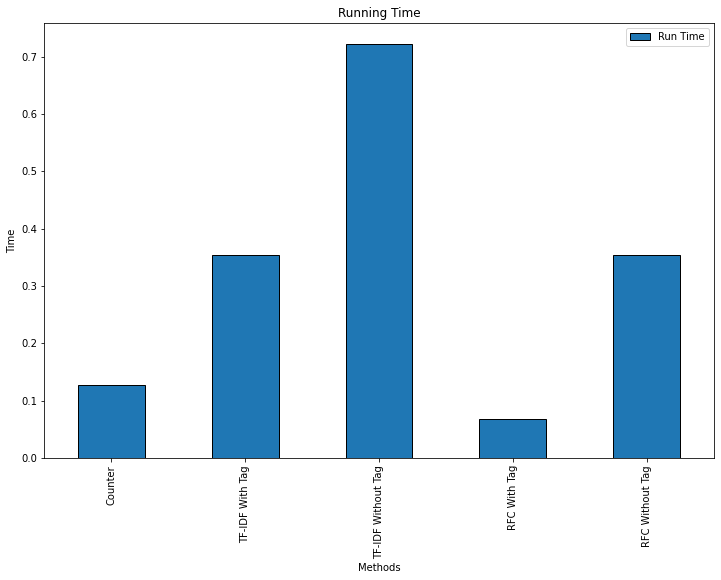

In [54]:
import matplotlib.pyplot as plt
labels = ['Counter','TF-IDF With Tag','TF-IDF Without Tag','RFC With Tag','RFC Without Tag']
index = [i for i in range(6)]
df = pd.DataFrame({'Run Time' : [Counter_time,Tag_Tfidf_time,Tfidf_time,tag_RFC_time,RFC_time]}
                , index = labels)
ax = df.plot.bar(rot=90, edgecolor = 'black',figsize=(12, 8))


plt.title("Running Time")
plt.xlabel("Methods")
plt.ylabel("Time")

Text(0, 0.5, 'Accuracy')

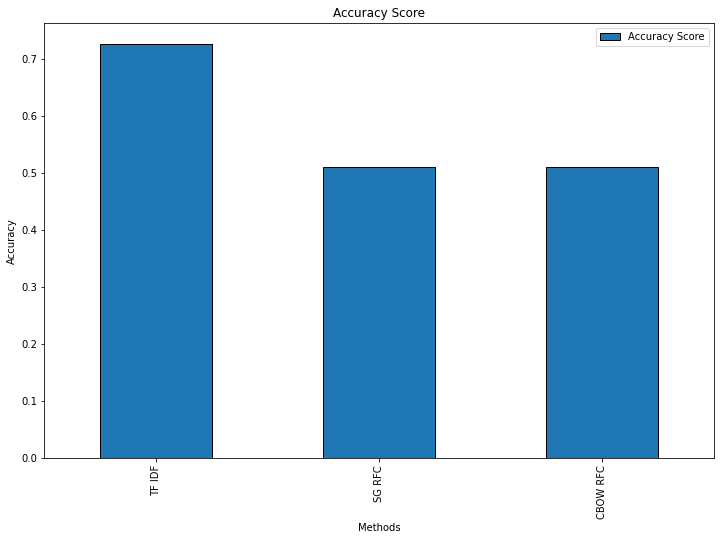

In [61]:
labels = ["TF IDF","SG RFC","CBOW RFC"]
index = [i for i in range(6)]
df1 = pd.DataFrame({'Accuracy Score' : [TF_IDF,SG_RFC,BOW_RFC]}
                , index = labels)
ax = df1.plot.bar(rot=90, edgecolor = 'black',figsize=(12, 8))


plt.title("Accuracy Score")
plt.xlabel("Methods")
plt.ylabel("Accuracy")